In [1]:
from ott.neural.models.models import NeuralVectorField
from ott.neural.solvers.flows import UniformSampler, ConstantNoiseFlow, OffsetUniformSampler
from ott.neural.solvers.otfm import OTFlowMatching
from ott.solvers.linear import sinkhorn

import optax
import scanpy as sc

from typing import Optional, Dict, Iterator

import jax
import jax.numpy as jnp

import numpy as np


from ott.tools import sinkhorn_divergence
from ott.geometry import pointcloud

In [2]:
adata_1M = sc.read('/home/icb/jonas.flor/gastrulation_atlas/scvi/training/1M/2k_genes/unintegrated_adata.h5ad')
adata_1M

/home/icb/jonas.flor/mambaforge/envs/moscot_flow/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 1000000 × 2000
    obs: 'cell_id', 'keep', 'day', 'embryo_id', 'experimental_batch', 'batch', 'cell_cluster', 'celltype', 'cellcluster_moscot', '_scvi_batch', '_scvi_labels', 'dpt_pseudotime'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'diffmap_evals', 'iroot', 'log1p', 'neighbors'
    obsm: 'X_diffmap', 'X_pca'
    obsp: 'connectivities', 'distances'

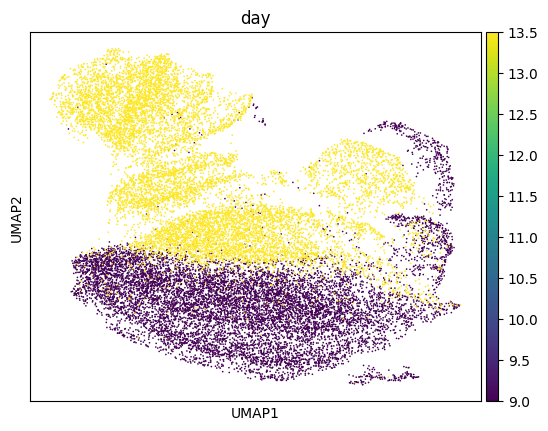

In [3]:
adata_tmp = adata_1M[[x in [9, 13.5] for x in adata_1M.obs.day]]
sc.pp.neighbors(adata_tmp)
sc.tl.umap(adata_tmp)
sc.pl.umap(adata_tmp, color='day')

In [4]:
class DataLoader:

  def __init__(
      self,
      source_data: jax.Array,
      target_data: jax.Array,
      conditions: Optional[jax.Array],
      batch_size: int = 64
  ) -> None:
    super().__init__()
    self.source_data = source_data
    self.target_data = target_data
    self.conditions = conditions
    self.batch_size = batch_size
    self.key = jax.random.PRNGKey(0)

  def __next__(self) -> jax.Array:
    key, self.key = jax.random.split(self.key)
    inds_source = jax.random.choice(
        key, len(self.source_data), shape=[self.batch_size]
    )
    inds_target = jax.random.choice(
        key, len(self.target_data), shape=[self.batch_size]
    )
    return self.source_data[inds_source, :], self.target_data[
        inds_target, :], self.conditions[
            inds_source] if self.conditions is not None else None

In [ ]:
adata_loader = DataLoader(adata_1M[adata_1M.obs['day']==9].obsm['X_pca'], adata_1M[adata_1M.obs['day']==13.5].obsm['X_pca'], conditions=None)

neural_vf = NeuralVectorField(
    output_dim=50,
    condition_dim=0,
    latent_embed_dim=256,
    n_frequencies=128
)
ot_solver = sinkhorn.Sinkhorn()
time_sampler = UniformSampler()
optimizer = optax.adam(learning_rate=1e-4)
fm = OTFlowMatching(
    neural_vf,
    input_dim=50,
    cond_dim=0,
    iterations=50000,
    valid_freq=2,
    ot_solver=ot_solver,
    flow=ConstantNoiseFlow(0.0),
    time_sampler=time_sampler,
    optimizer=optimizer
)
fm(adata_loader, adata_loader)

In [ ]:
adata_concat = sc.concat(
    {'9.00': adata_1M[adata_1M.obs.day==9], '9.00_push': adata_1M[adata_1M.obs.day==9], '13.5': adata_1M[adata_1M.obs.day==13.5]},
    label='day_umap'
)  
adata_concat.obsm["X_new"] = np.concatenate(
    (adata_1M[adata_1M.obs.day==9].obsm['X_pca'], np.array(fm.transport(jnp.array(adata_1M[adata_1M.obs['day']==9].obsm['X_pca']), condition=None, forward=True)), adata_1M[adata_1M.obs.day==13.5].obsm['X_pca']),
    axis=0
)
adata_concat

In [ ]:
del adata_concat.obsm['X_diffmap']

sc.pp.neighbors(adata_concat, use_rep='X_new')
sc.tl.umap(adata_concat)
sc.pl.umap(adata_concat, color='day_umap')

In [ ]:
adata_con_2 = adata_concat[adata_concat.obs['day_umap']!='9.00'].copy()
sc.pp.neighbors(adata_con_2, use_rep='X_new')
sc.tl.umap(adata_con_2)
sc.pl.umap(adata_con_2, color='day_umap')

In [ ]:
adata_con_3 = adata_concat[adata_concat.obs['day_umap']!='9.00_push'].copy()
sc.pp.neighbors(adata_con_3, use_rep='X_new')
sc.tl.umap(adata_con_3)
sc.pl.umap(adata_con_3, color='day_umap')